In [11]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn-v0_8')
sns.set_palette('Set2')

%matplotlib inline

### Überblick über den Datensatz

Der analysierte Datensatz besteht aus bereinigten und feature-engineerten Transaktionsdaten und enthält sowohl numerische als auch kategoriale Merkmale. Die Struktur ist konsistent, vollständig und für eine weitere Modellierung geeignet.

Die Trennung zwischen Eingangsmerkmalen und Zielvariable (`FraudResult`) ist klar definiert, wodurch potenzielles Data Leakage vermieden wird. Insgesamt stellt der Datensatz eine stabile Grundlage für die nachfolgenden Analyse- und Modellierungsschritte dar.


In [12]:
Data_PATH = "../data/processed/training_preprocessed.csv"

df = pd.read_csv(Data_PATH)

df.head()

,ProviderId,ProductId,ProductCategory,ChannelId,Amount,Value,PricingStrategy,FraudResult,ts_month,ts_is_weekend,ts_is_night,ts_hour_sin,ts_hour_cos,ts_dow_sin,ts_dow_cos,log_value,amount_value_ratio
0,ProviderId_6,ProductId_10,airtime,ChannelId_3,1000.0,1000,2,0,11,0,1,0.500000,0.866025,0.433884,-0.900969,6.908755,0.999001
1,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-20.0,20,2,0,11,0,1,0.500000,0.866025,0.433884,-0.900969,3.044522,0.952381
2,ProviderId_6,ProductId_1,airtime,ChannelId_3,500.0,500,2,0,11,0,1,0.500000,0.866025,0.433884,-0.900969,6.216606,0.998004
3,ProviderId_1,ProductId_21,utility_bill,ChannelId_3,20000.0,21800,2,0,11,0,1,0.707107,0.707107,0.433884,-0.900969,9.989711,0.917389
4,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-644.0,644,2,0,11,0,1,0.707107,0.707107,0.433884,-0.900969,6.469250,0.998450


### Analyse der Zielvariable (FraudResult)

Die Zielvariable weist eine stark unausgeglichene Klassenverteilung auf, wobei betrügerische Transaktionen nur einen sehr kleinen Anteil des Datensatzes ausmachen. Dieses Verhalten ist typisch für reale Betrugserkennungsprobleme.

Der beobachtete Klassenimbalance macht deutlich, dass klassische Metriken wie Accuracy ungeeignet sind. Stattdessen werden im weiteren Verlauf spezialisierte Metriken sowie geeignete Trainingsstrategien erforderlich sein.


Übersicht Betrug vs. Nicht-Betrug


,Anzahl,Prozent (%)
Nicht-Betrug,95263,99.800000
Betrug,193,0.200000


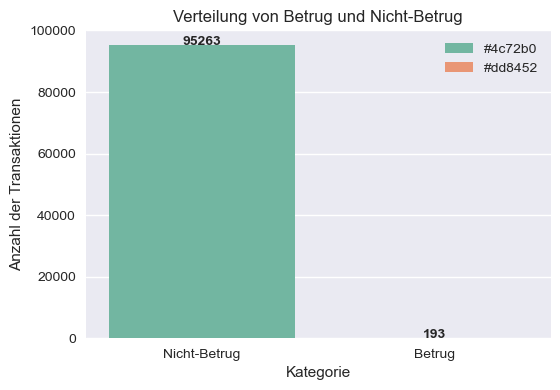

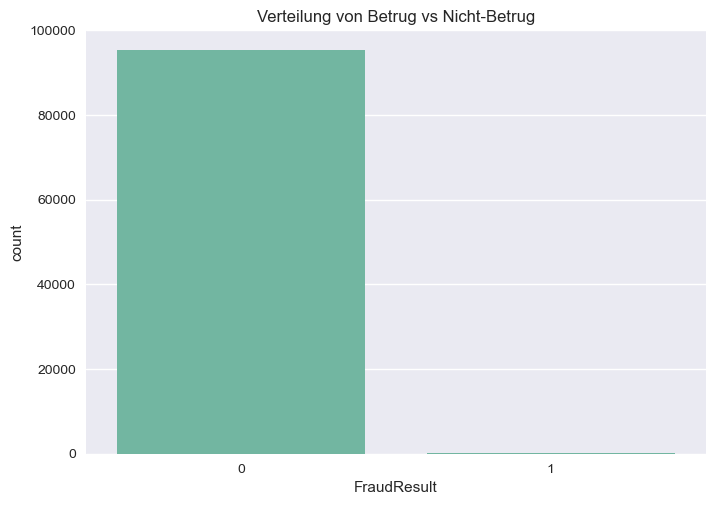

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

fraud_counts = df['FraudResult'].value_counts()
fraud_table = pd.DataFrame({
    'Anzahl': fraud_counts,
    'Prozent (%)': (fraud_counts / fraud_counts.sum() * 100).round(2)
})

fraud_table.index = ['Nicht-Betrug', 'Betrug']

print("Übersicht Betrug vs. Nicht-Betrug")
display(fraud_table.style.background_gradient(cmap='Reds'))

plt.figure(figsize=(6,4))
sns.barplot(x=fraud_table.index, y=fraud_table['Anzahl'], palette='Set2',hue=['#4c72b0', '#dd8452'])
plt.title("Verteilung von Betrug und Nicht-Betrug")
plt.xlabel("Kategorie")
plt.ylabel("Anzahl der Transaktionen")

# Ajouter les valeurs au-dessus des barres
for i, val in enumerate(fraud_table['Anzahl']):
    plt.text(i, val + 50, str(val), ha='center', fontweight='bold')

plt.show()

sns.countplot(x='FraudResult', data=df)
plt.title("Verteilung von Betrug vs Nicht-Betrug")  
plt.show() 


### Univariate Analyse numerischer Merkmale

In diesem Abschnitt werden die numerischen Merkmale unabhängig von der Zielvariable analysiert. Ziel ist es, die Verteilungen der Features zu untersuchen sowie mögliche Ausreißer, Schiefe und Skaleneffekte zu identifizieren.

Insbesondere bei betragsbezogenen Variablen ist eine starke Rechtsschiefe zu erwarten, was die Notwendigkeit geeigneter Transformationen (z. B. Log-Transformation) für die spätere Modellierung unterstreicht.

Numerische Merkmale (12): ['Amount', 'Value', 'PricingStrategy', 'ts_month', 'ts_is_weekend', 'ts_is_night', 'ts_hour_sin', 'ts_hour_cos', 'ts_dow_sin', 'ts_dow_cos', 'log_value', 'amount_value_ratio']
Kategoriale Merkmale (4): ['ProviderId', 'ProductId', 'ProductCategory', 'ChannelId']



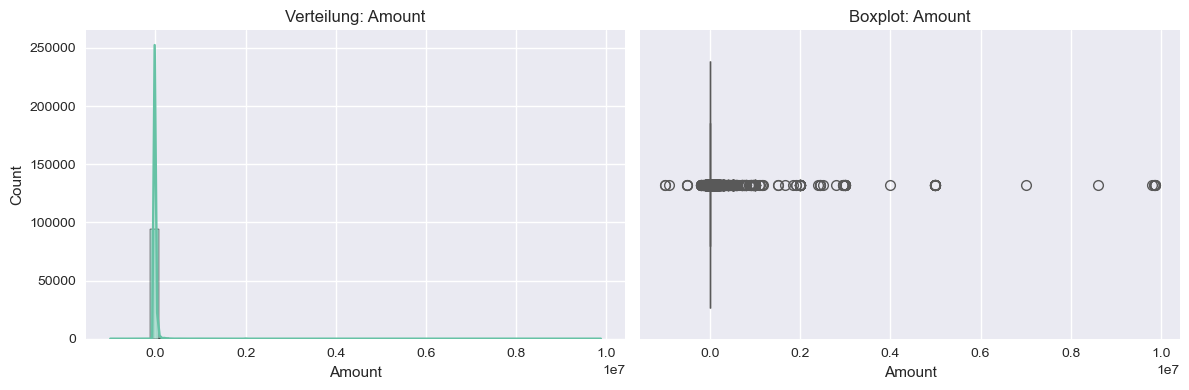

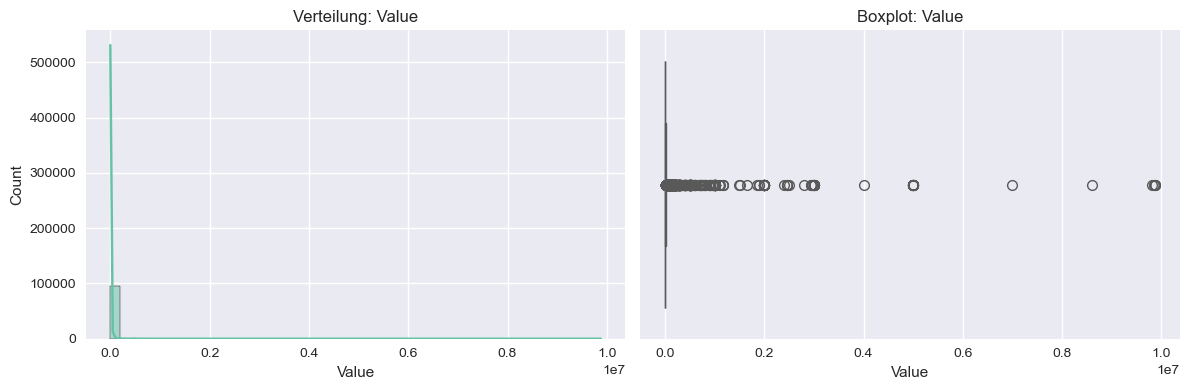

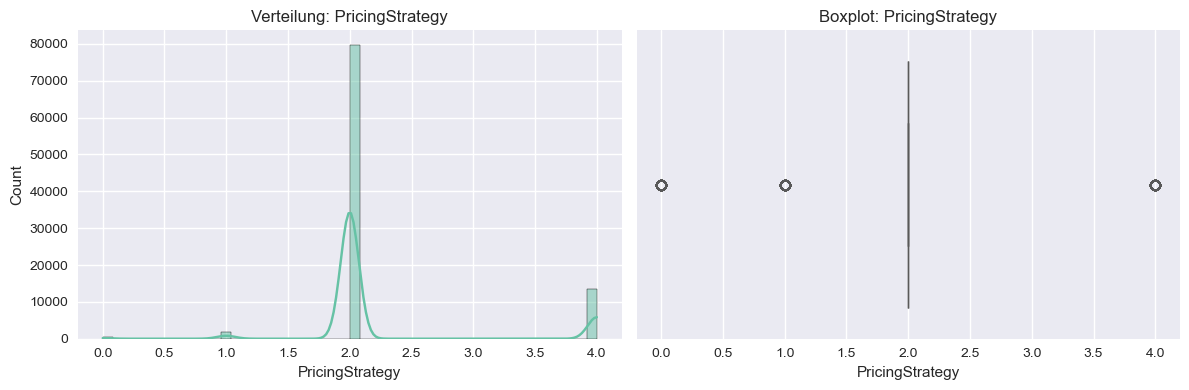

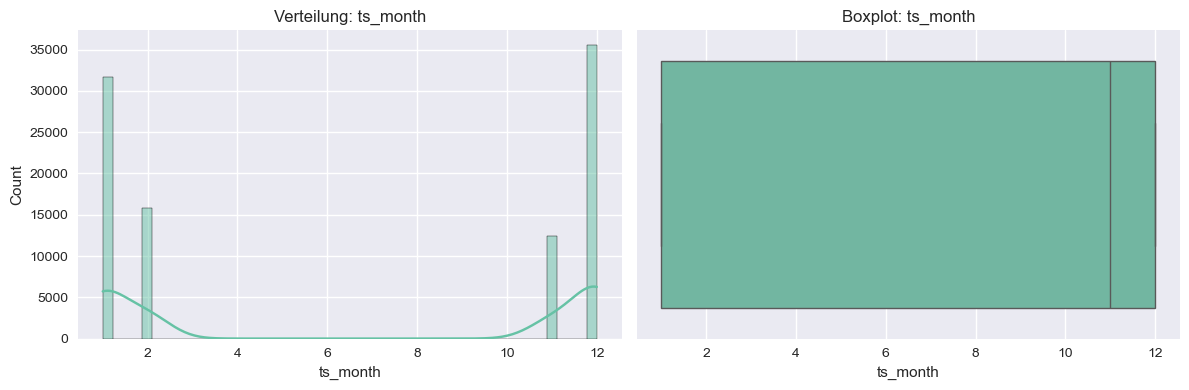

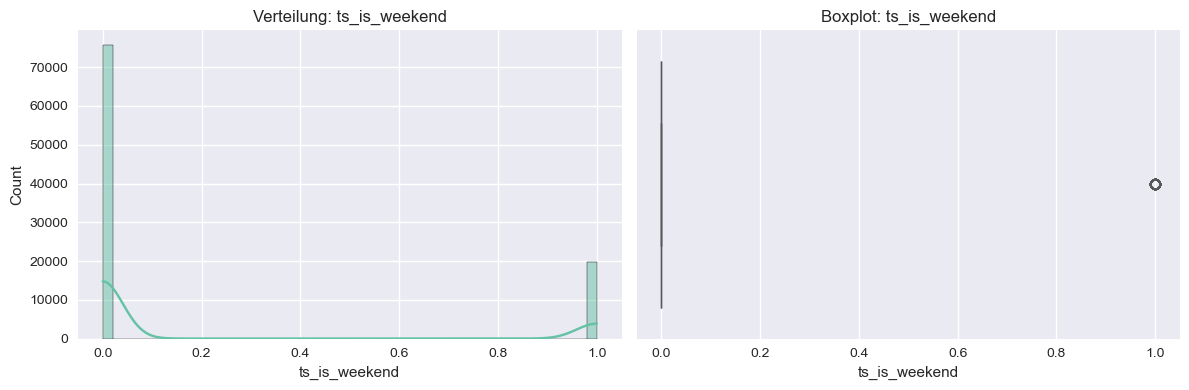

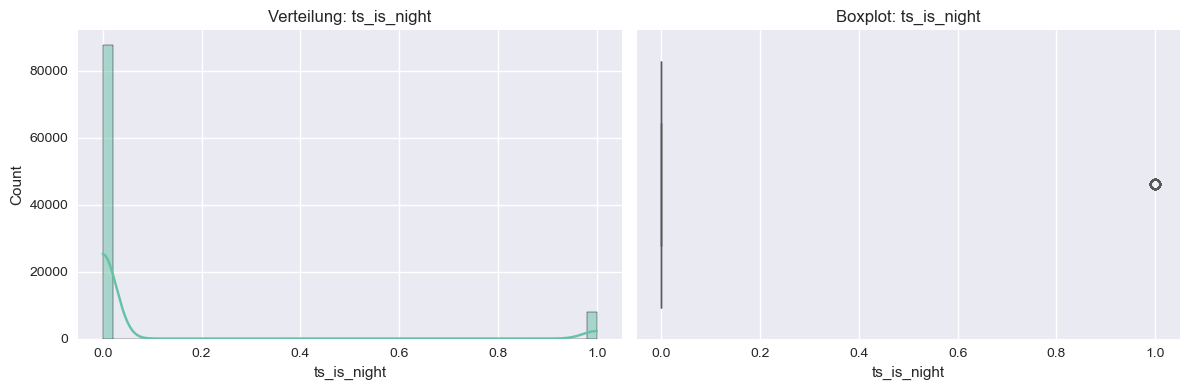

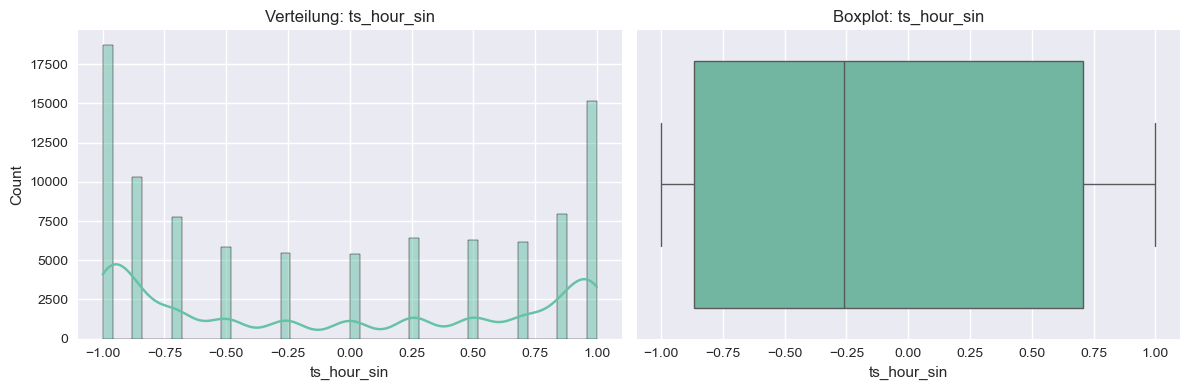

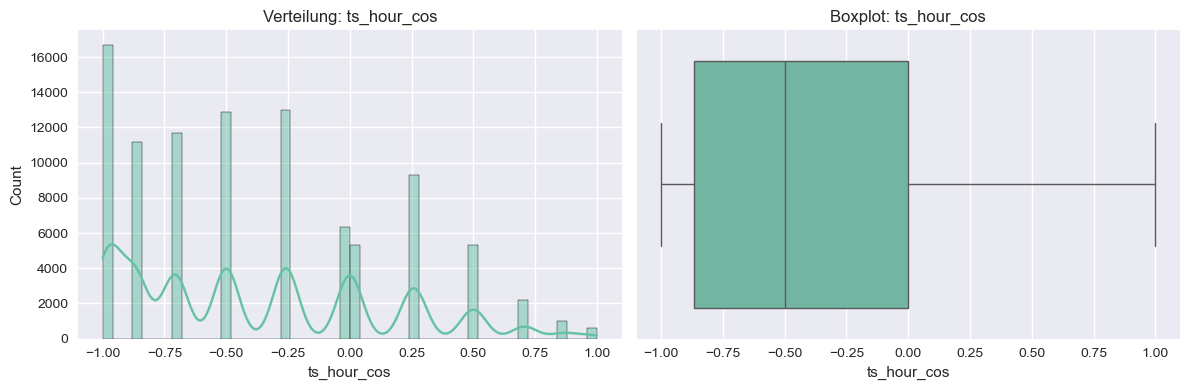

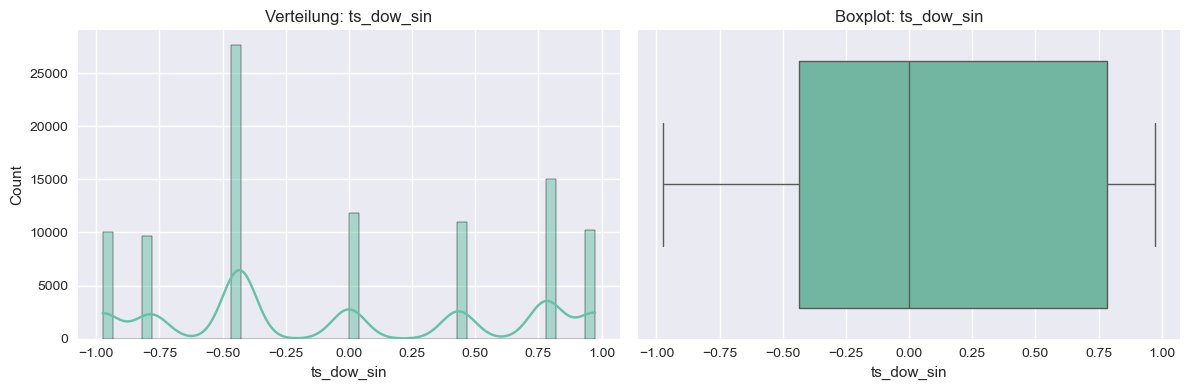

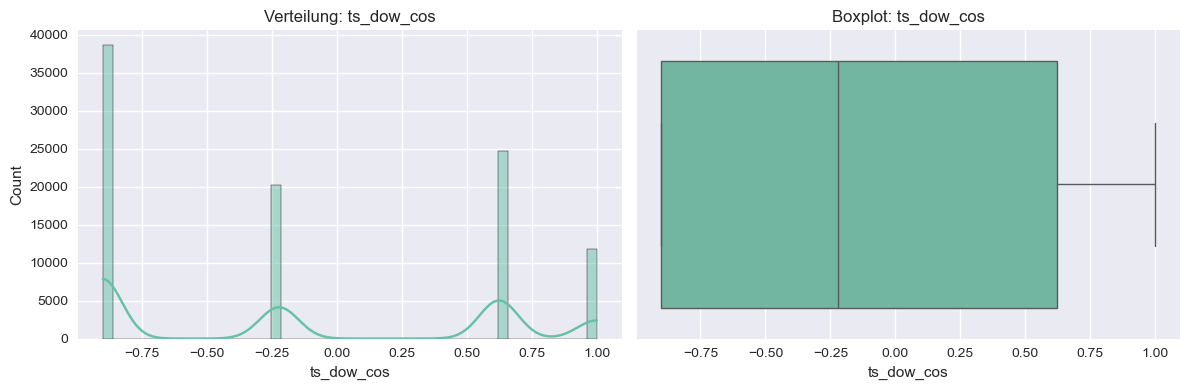

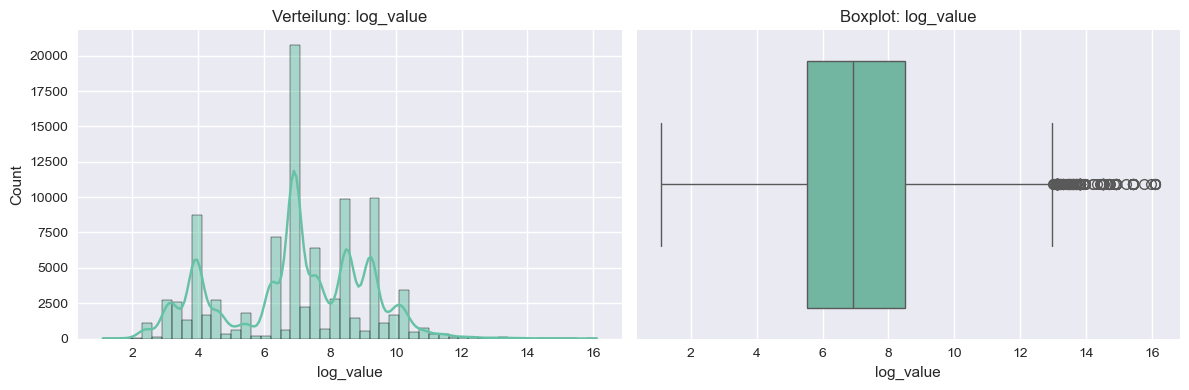

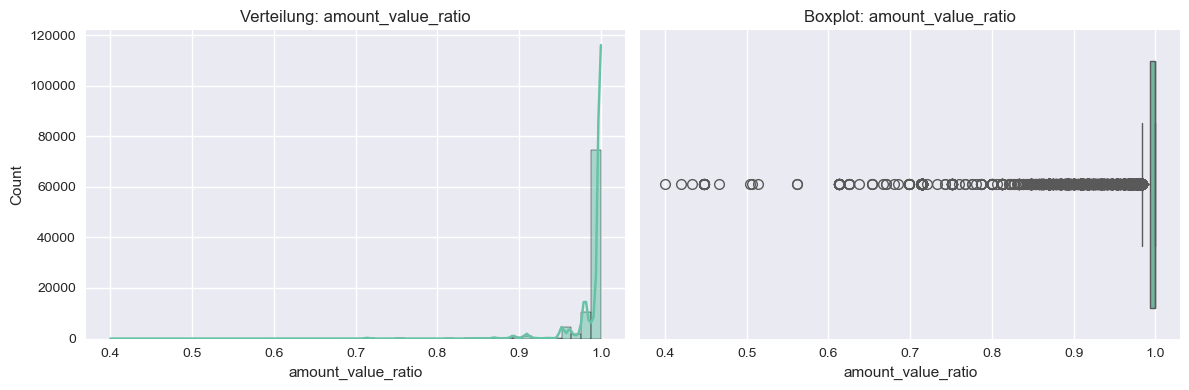

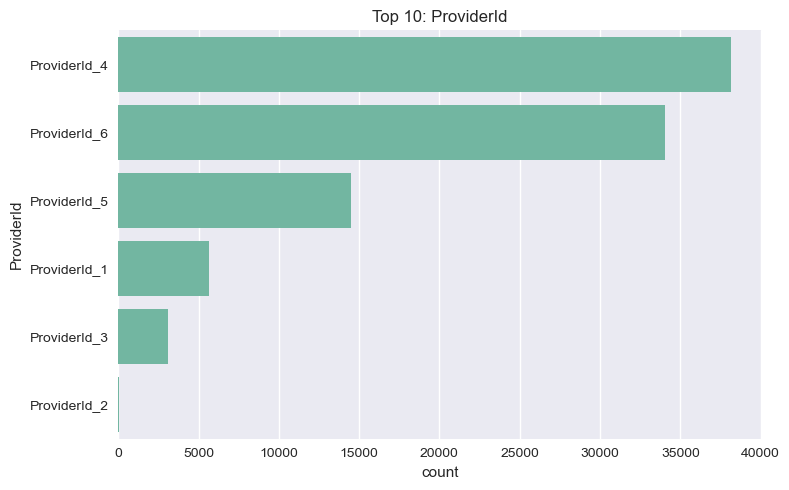

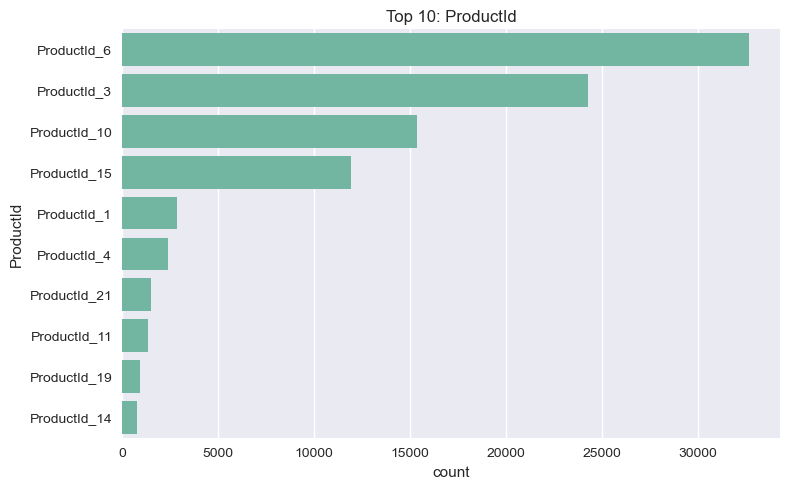

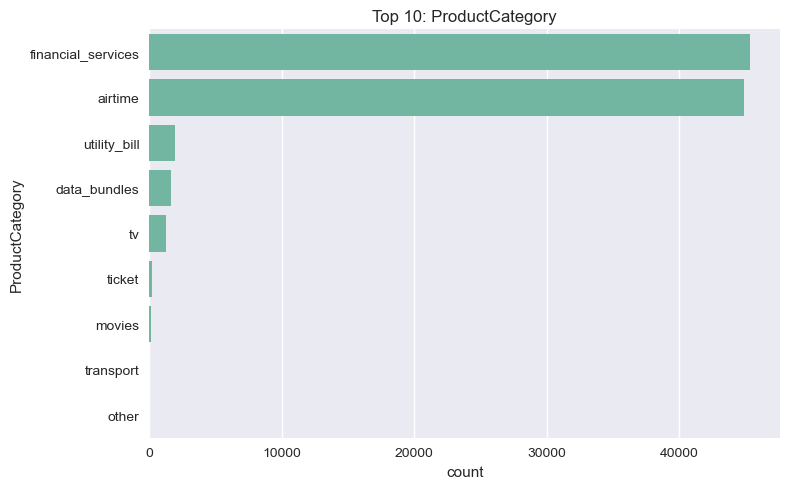

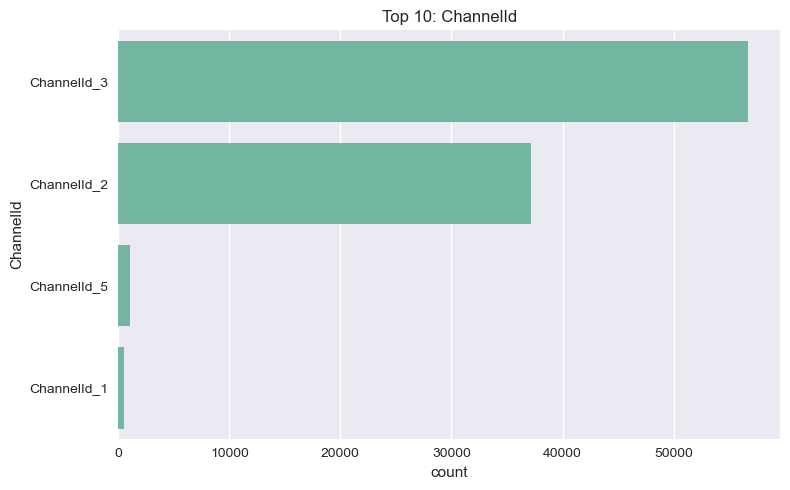

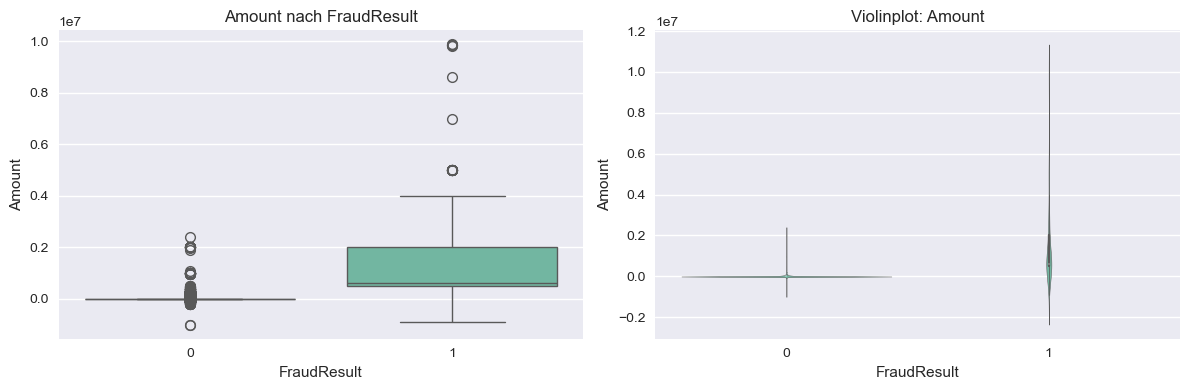

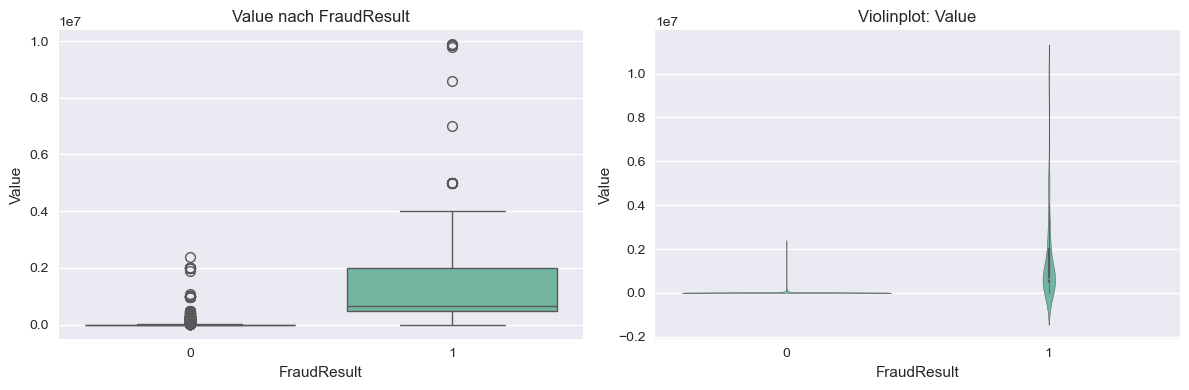

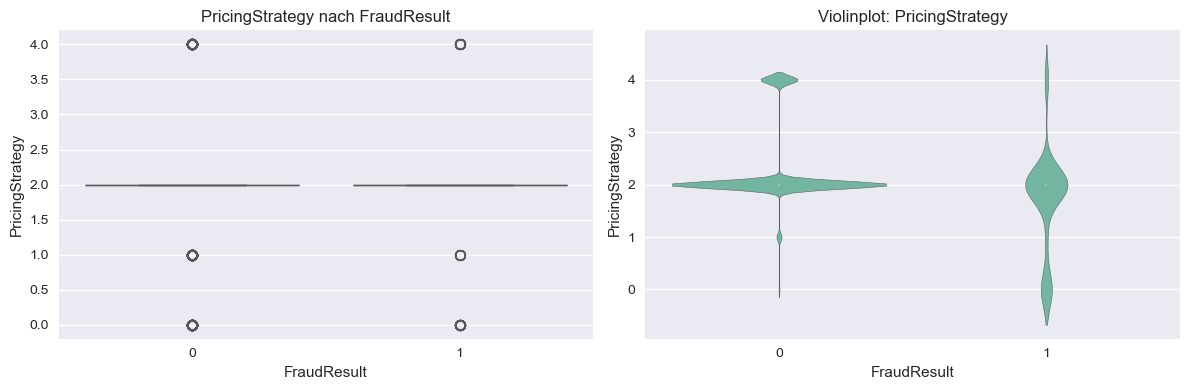

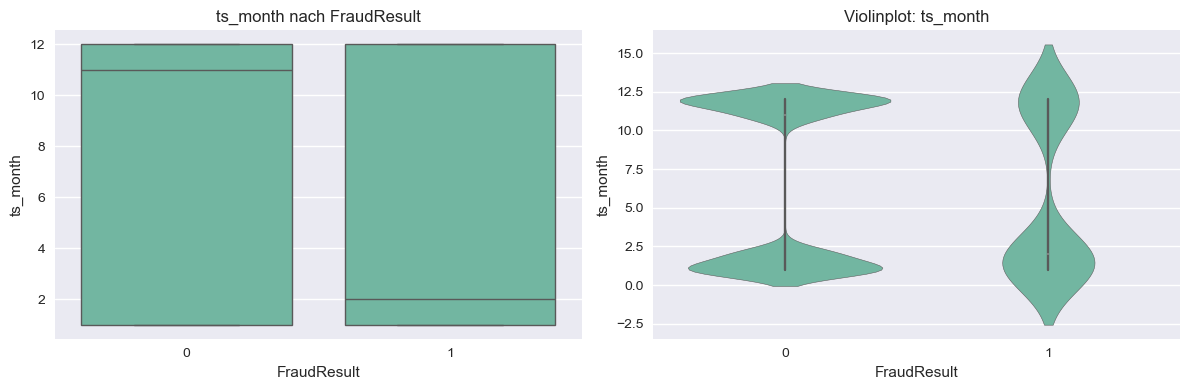

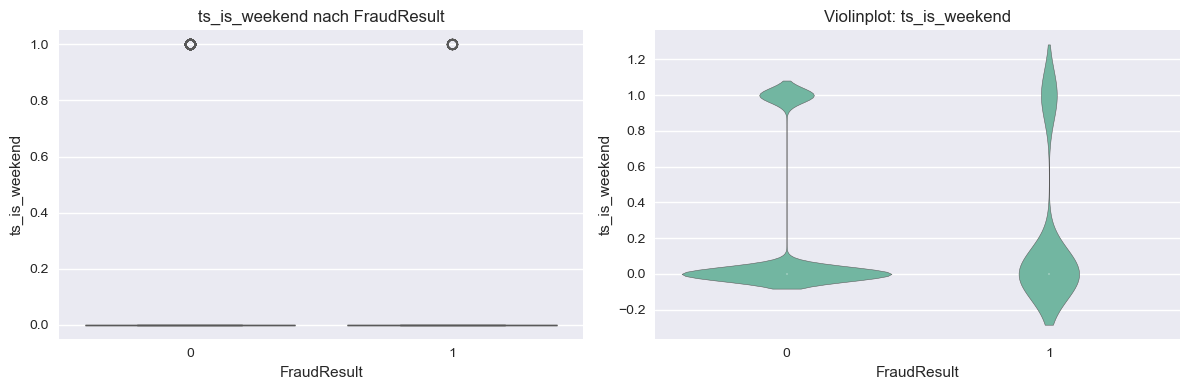

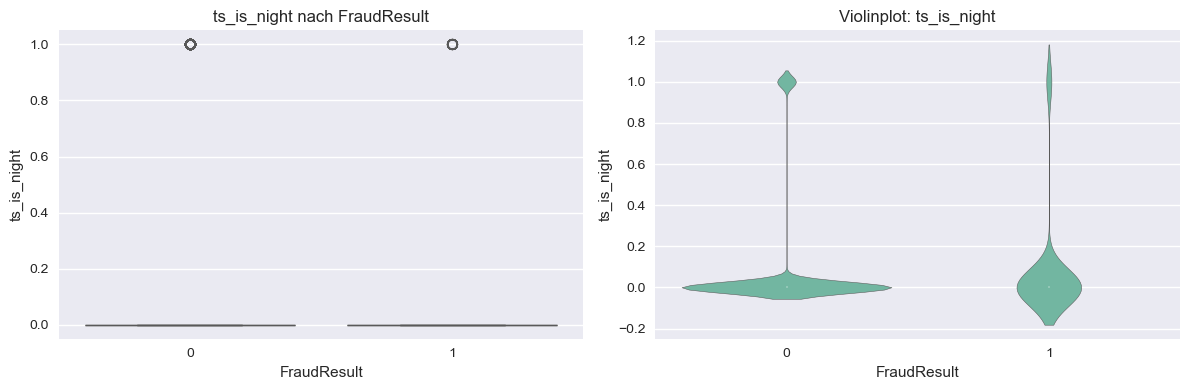

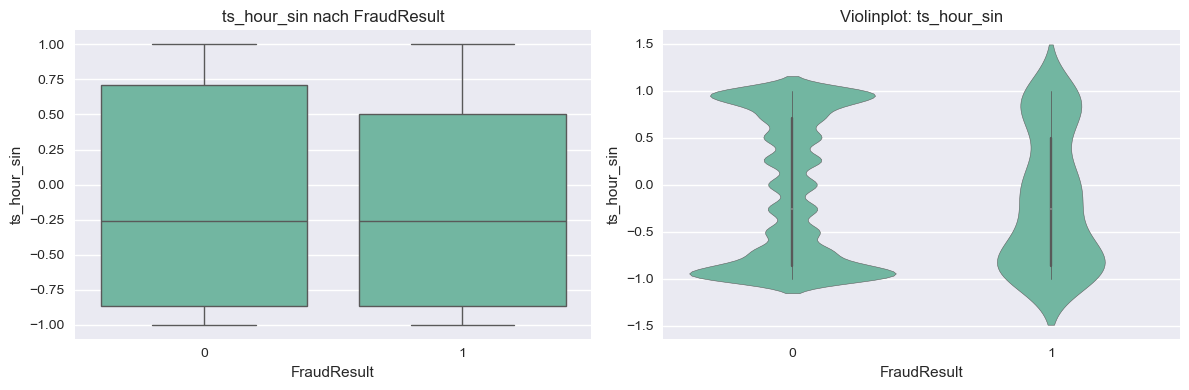

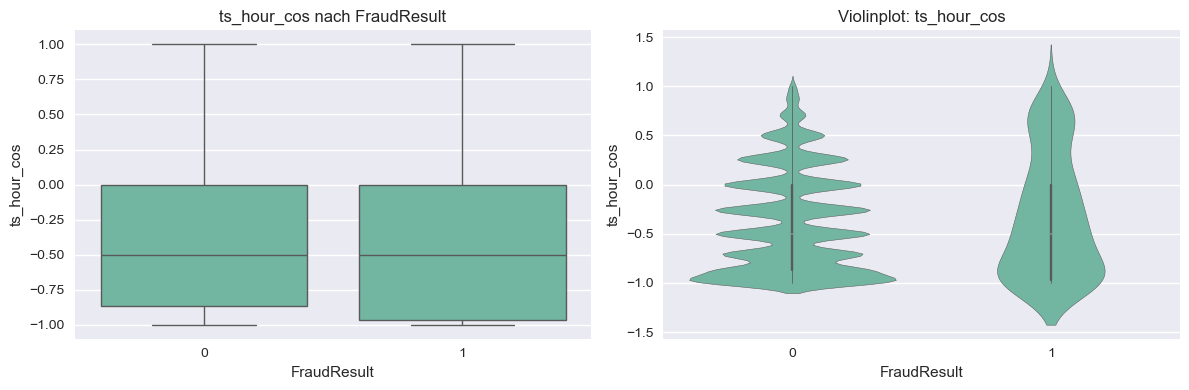

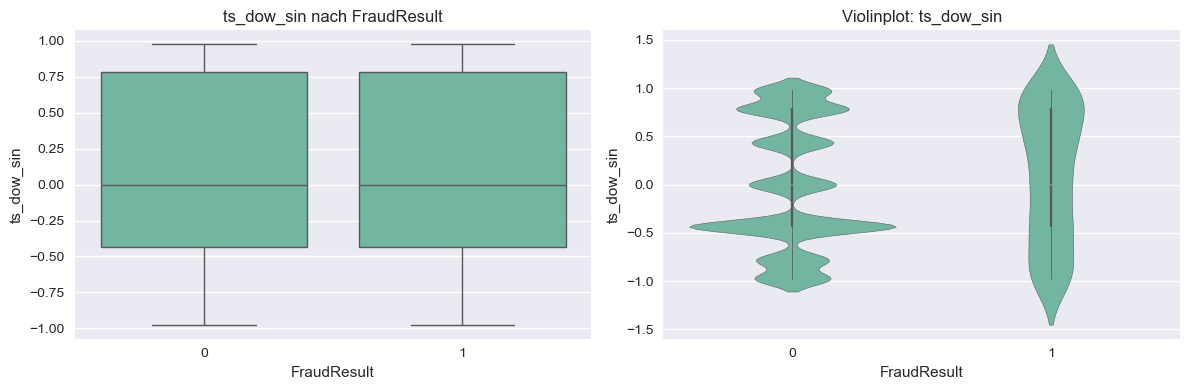

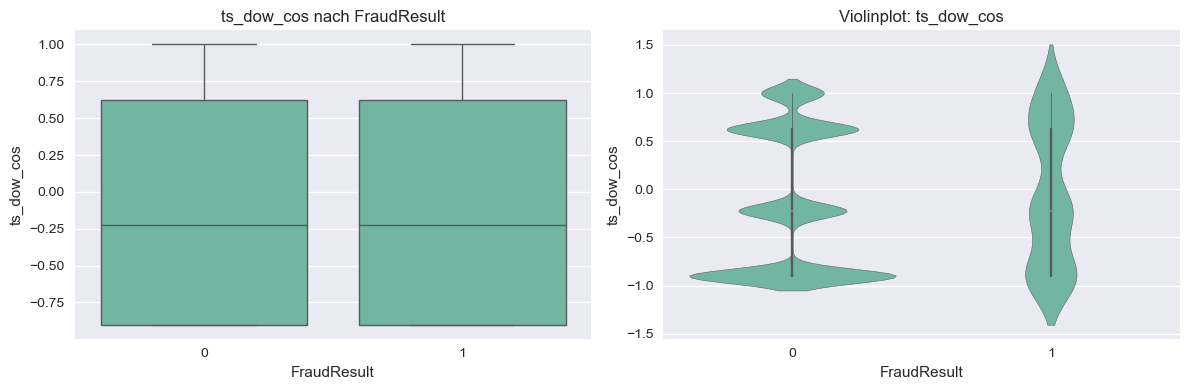

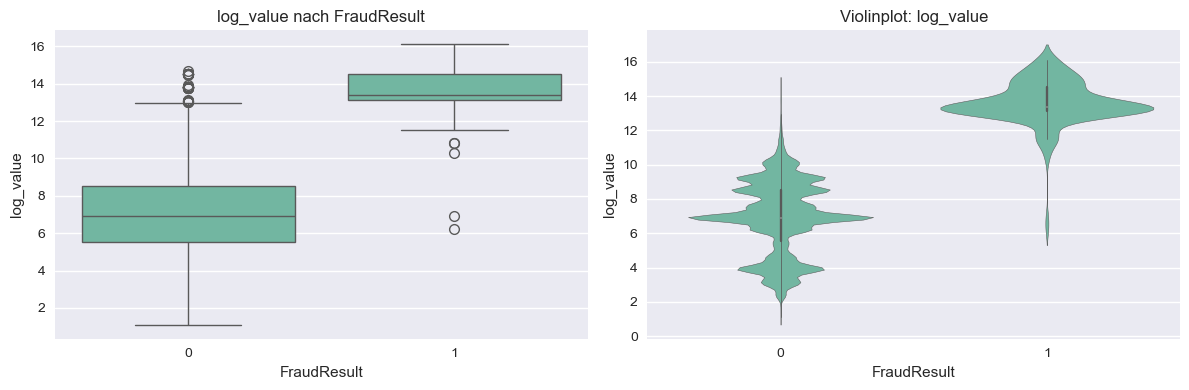

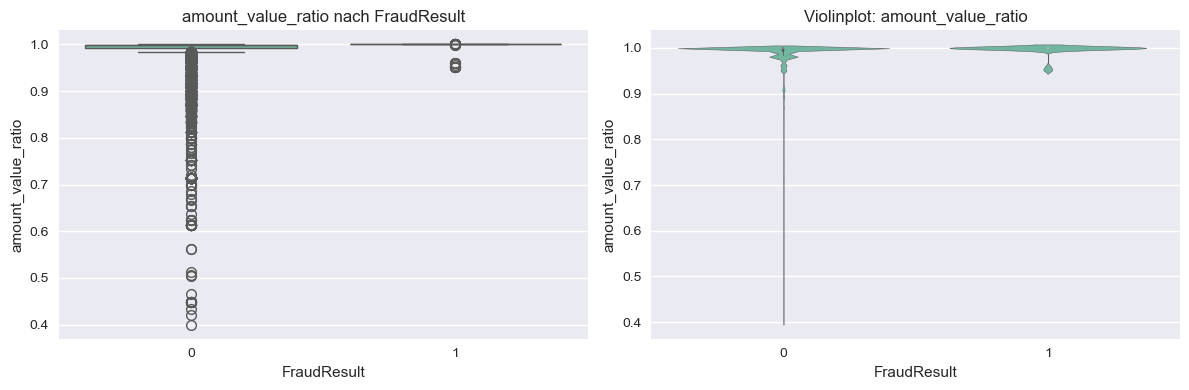

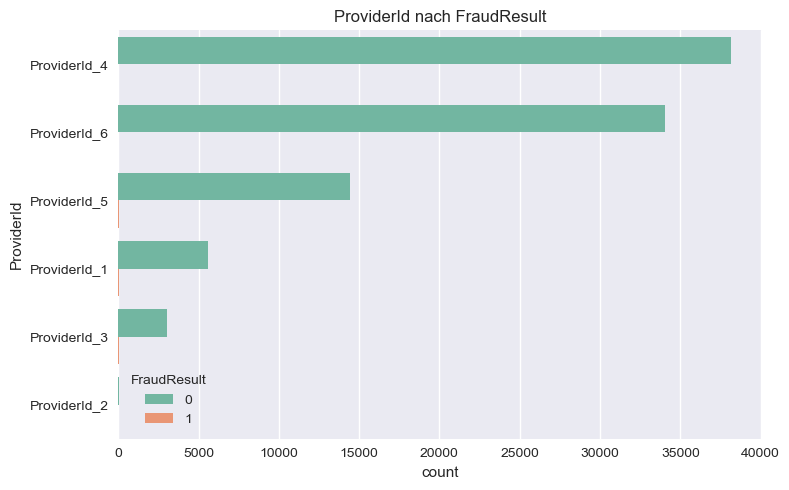

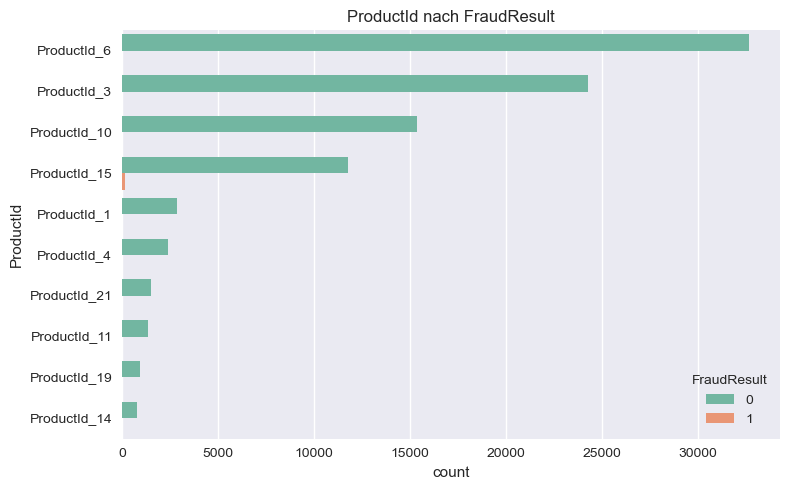

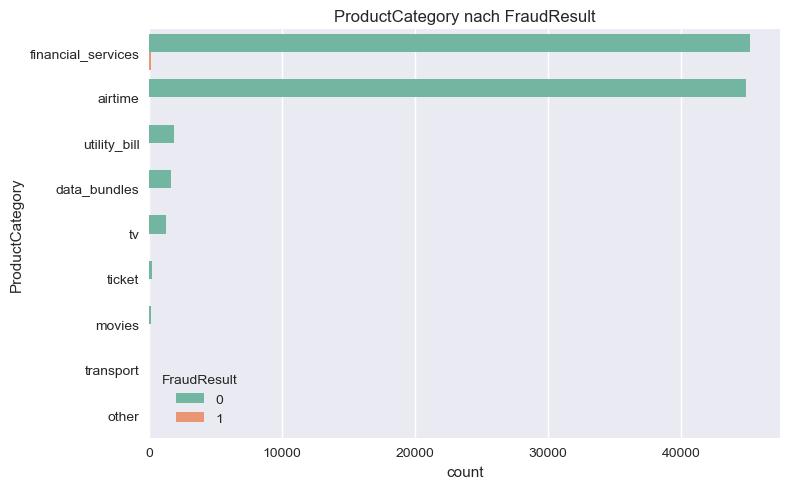

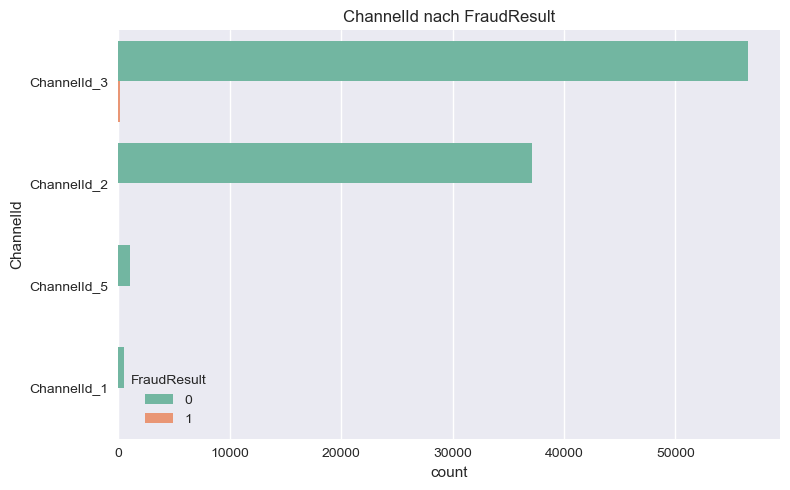

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn-v0_8')
sns.set_palette('Set2')
%matplotlib inline

# Extraktion der Merkmalslisten
TARGET = "FraudResult"
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
numeric_cols.remove(TARGET)
categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()

print(f"Numerische Merkmale ({len(numeric_cols)}): {numeric_cols}")
print(f"Kategoriale Merkmale ({len(categorical_cols)}): {categorical_cols}\n")

# Univariate Analyse: numerische Merkmale
for col in numeric_cols:
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    sns.histplot(df[col], bins=50, kde=True, ax=ax[0])
    ax[0].set_title(f"Verteilung: {col}")
    sns.boxplot(x=df[col], ax=ax[1])
    ax[1].set_title(f"Boxplot: {col}")
    plt.tight_layout()
    plt.show()

# Univariate Analyse: kategoriale Merkmale
for col in categorical_cols:
    plt.figure(figsize=(8, 5))
    sns.countplot(y=col, data=df, order=df[col].value_counts().head(10).index)
    plt.title(f"Top 10: {col}")
    plt.tight_layout()
    plt.show()

# Bivariate Analyse: numerische Merkmale vs. Zielvariable
for col in numeric_cols:
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    sns.boxplot(x=TARGET, y=col, data=df, ax=ax[0])
    ax[0].set_title(f"{col} nach {TARGET}")
    sns.violinplot(x=TARGET, y=col, data=df, ax=ax[1])
    ax[1].set_title(f"Violinplot: {col}")
    plt.tight_layout()
    plt.show()

# Bivariate Analyse: kategoriale Merkmale vs. Zielvariable
for col in categorical_cols:
    plt.figure(figsize=(8, 5))
    sns.countplot(y=col, hue=TARGET, data=df, order=df[col].value_counts().head(10).index)
    plt.title(f"{col} nach {TARGET}")
    plt.legend(title=TARGET)
    plt.tight_layout()
    plt.show()

### Korrelationsanalyse numerischer Merkmale

In diesem Abschnitt werden die Zusammenhänge zwischen den numerischen Merkmalen und der Zielvariable (FraudResult) untersucht. Ziel ist es, starke lineare Beziehungen, redundante Features und mögliche Multikollinearität zu erkennen.

Die Korrelationsmatrix bietet einen schnellen Überblick darüber, welche Variablen eng miteinander verknüpft sind und welche Merkmale einen direkten Einfluss auf Betrugsfälle haben. Diese Erkenntnisse sind besonders hilfreich für die Feature-Auswahl und zur Optimierung prädiktiver Modelle.


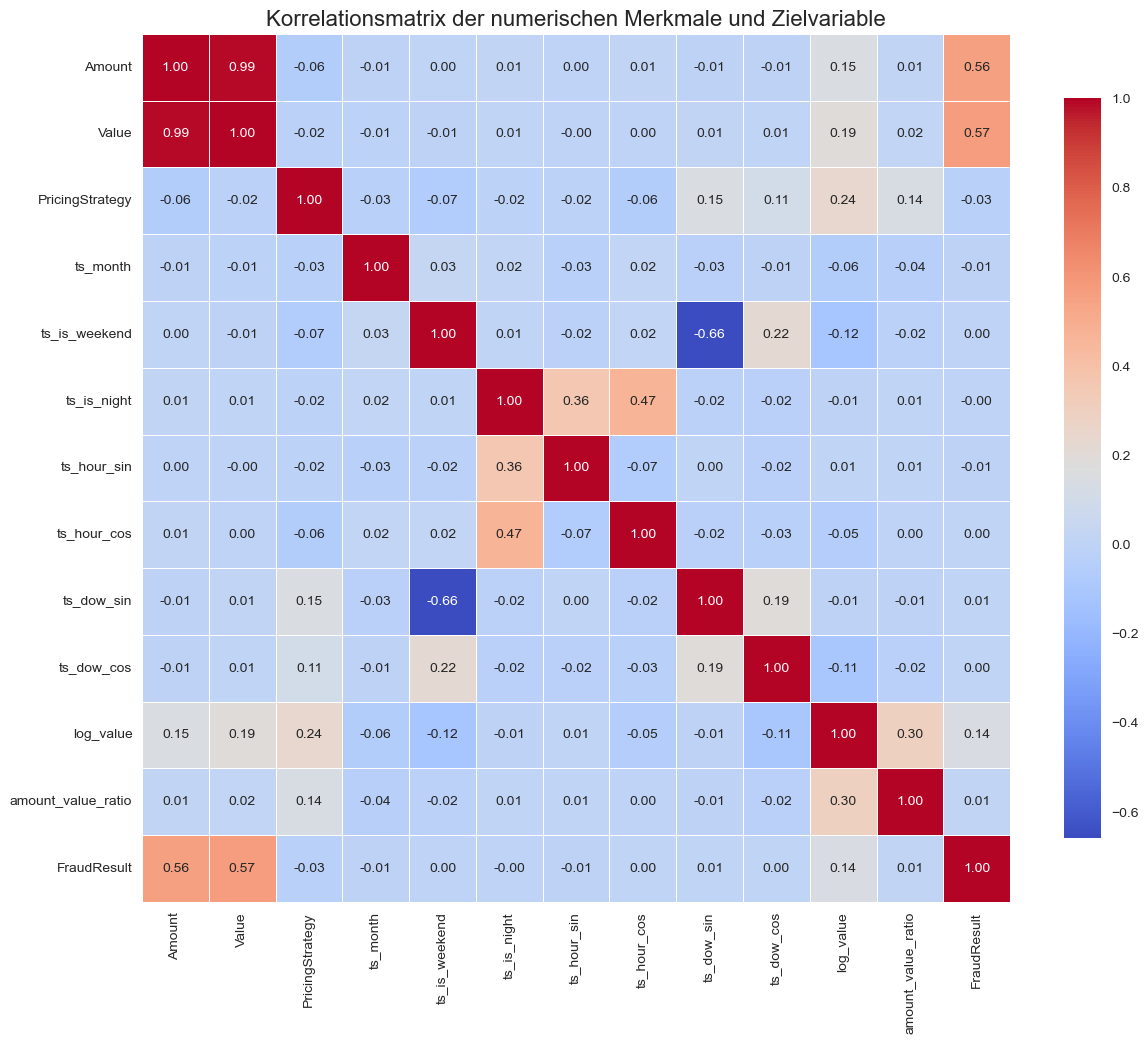

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns


plt.figure(figsize=(14, 12))

corr = df[numeric_cols + [TARGET]].corr()

sns.heatmap(
    corr, 
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    square=True,
    linewidths=0.5,
    cbar_kws={'shrink':0.8}
)

plt.title("Korrelationsmatrix der numerischen Merkmale und Zielvariable", fontsize=16)

plt.show()


### Analyse der Kombinationen und Wechselwirkungen von Variablen zur Betrugserkennung

In diesem Abschnitt werden Interaktionen zwischen Variablen untersucht, um Muster von Betrug zu erkennen, die bei der Analyse einzelner Merkmale nicht sichtbar sind. Heatmaps zeigen die Betrugsraten für Kombinationen kategorialer Variablen, während Boxplots die Verteilung numerischer Variablen nach Kategorie und Betrug darstellen


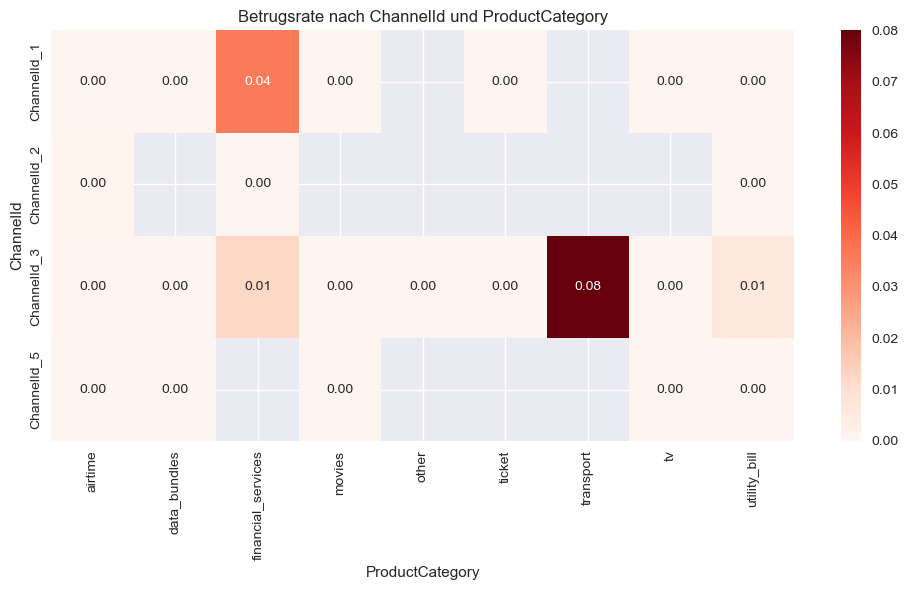

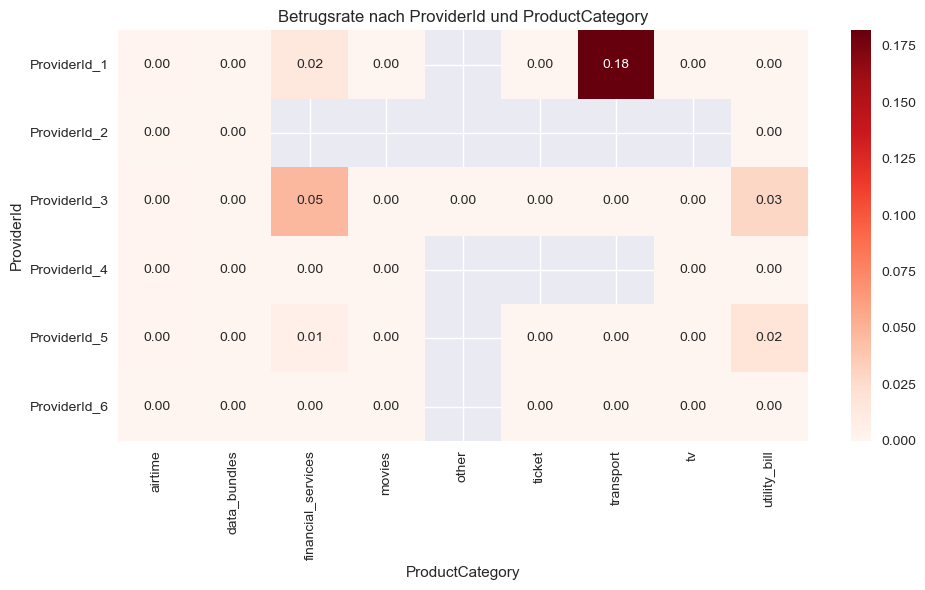

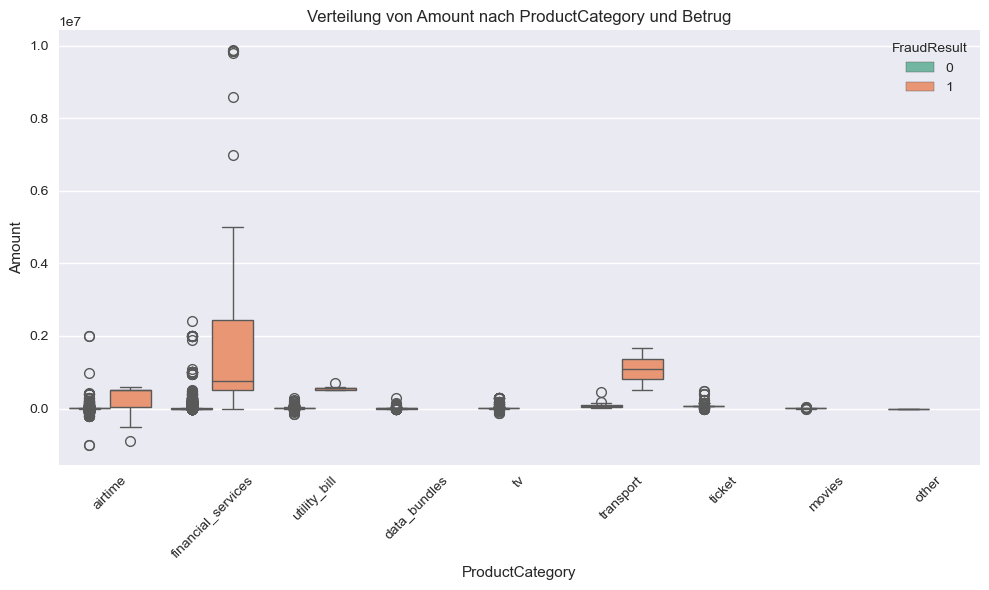

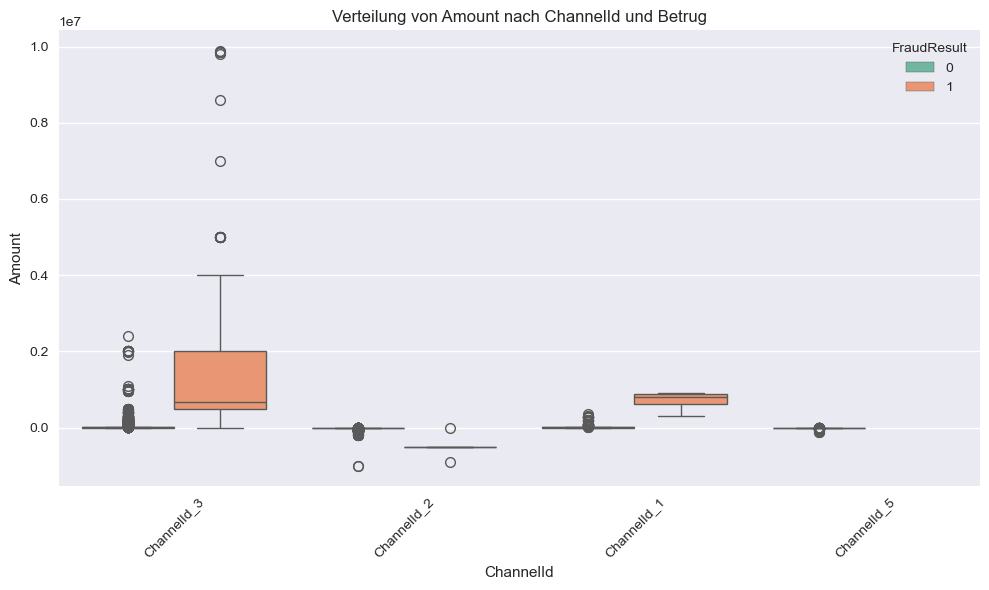

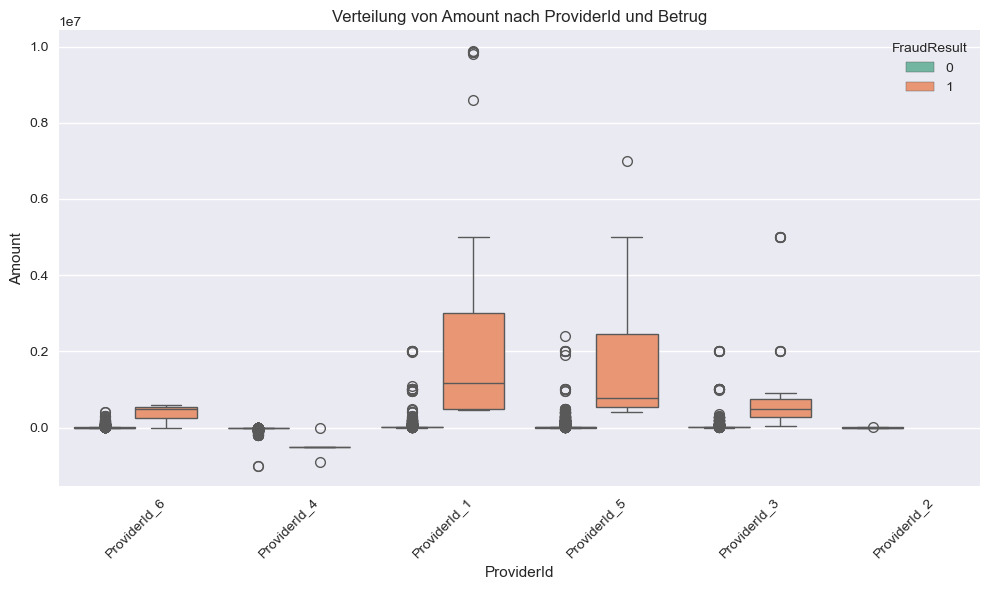

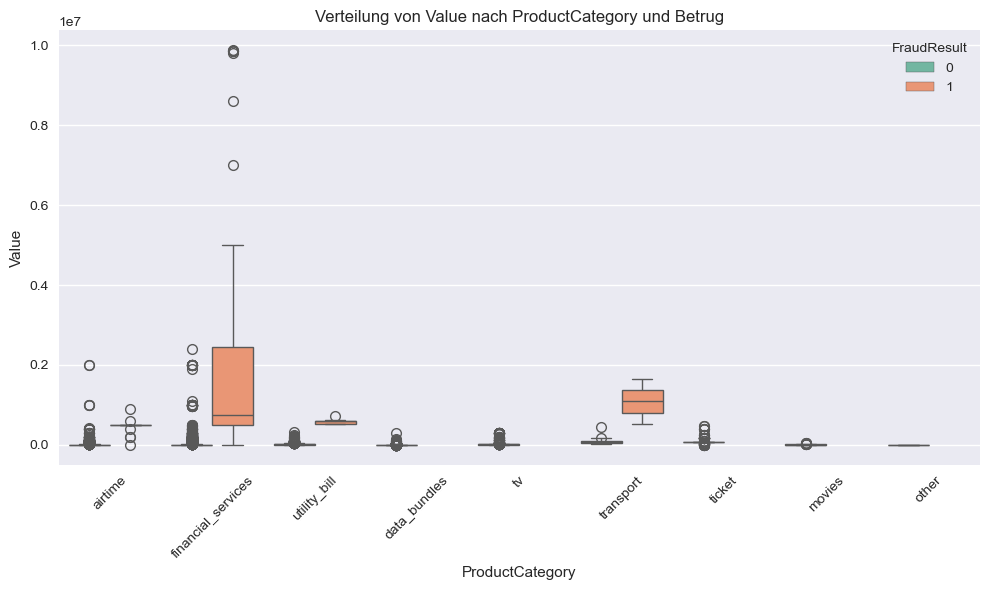

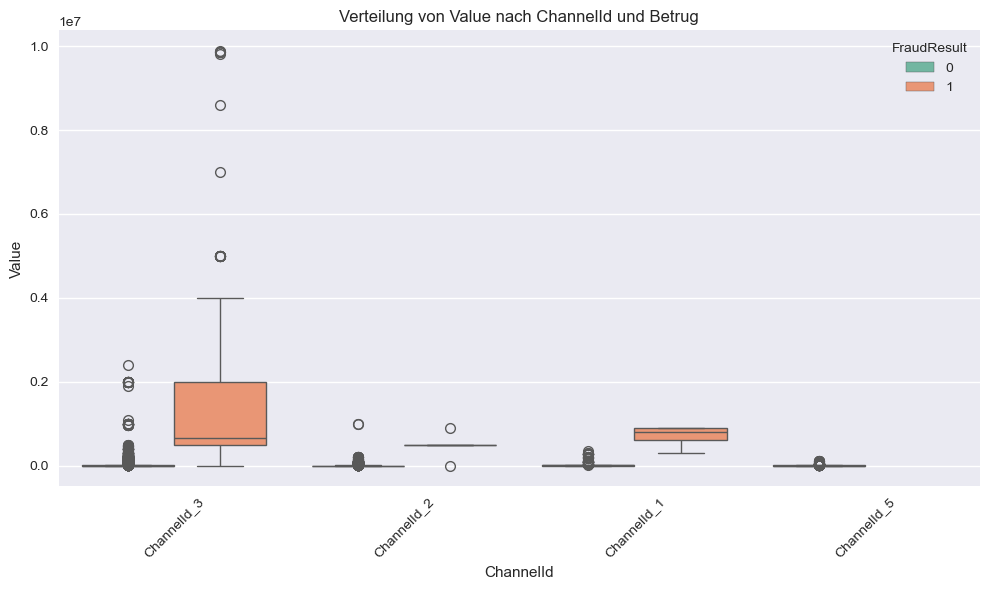

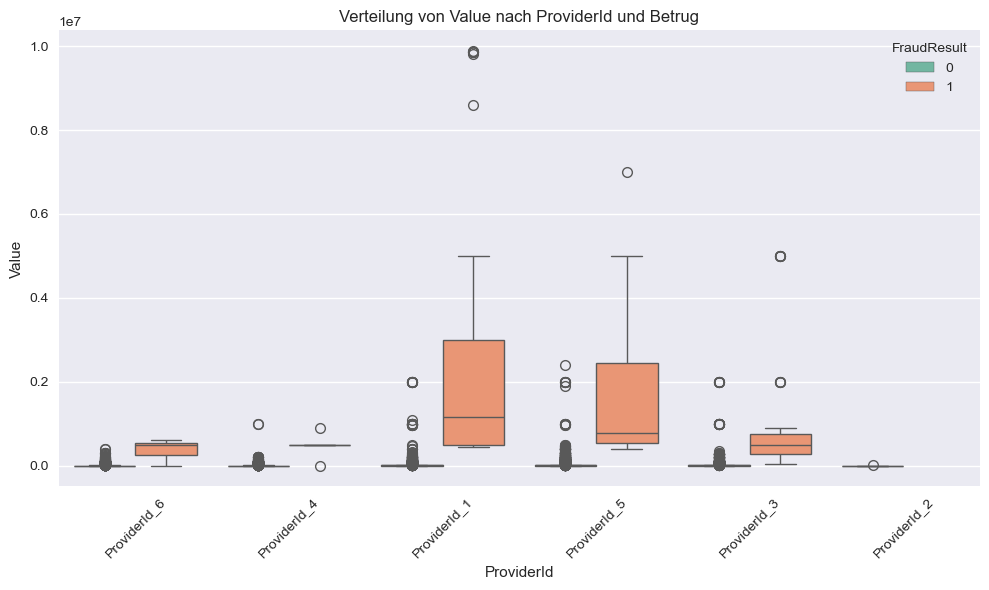

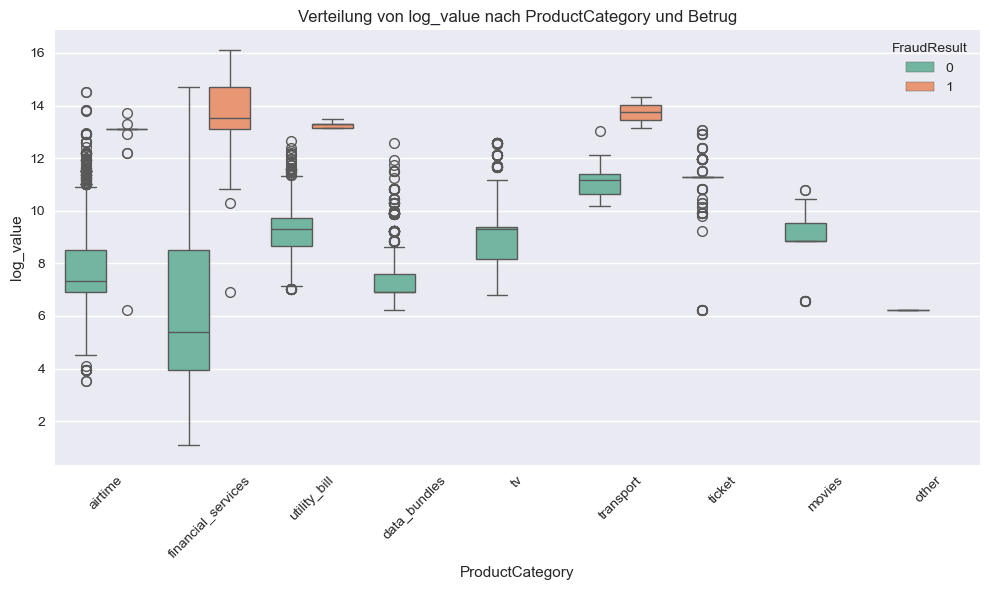

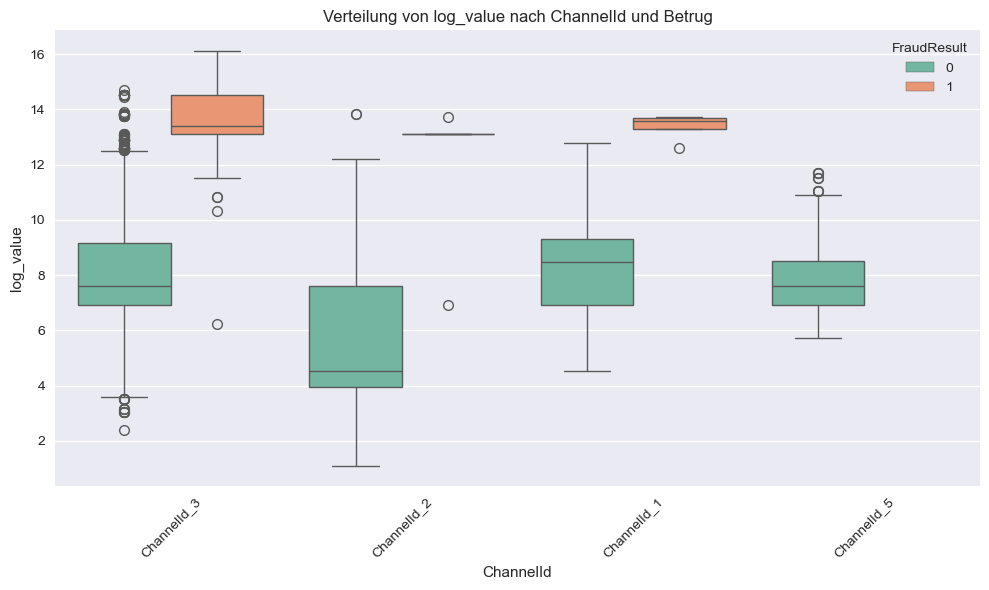

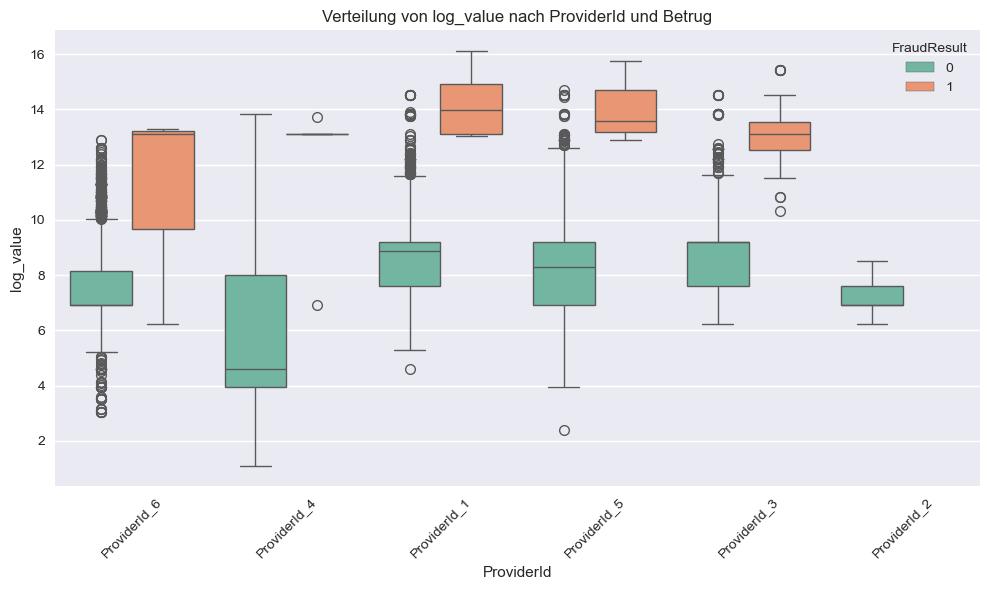

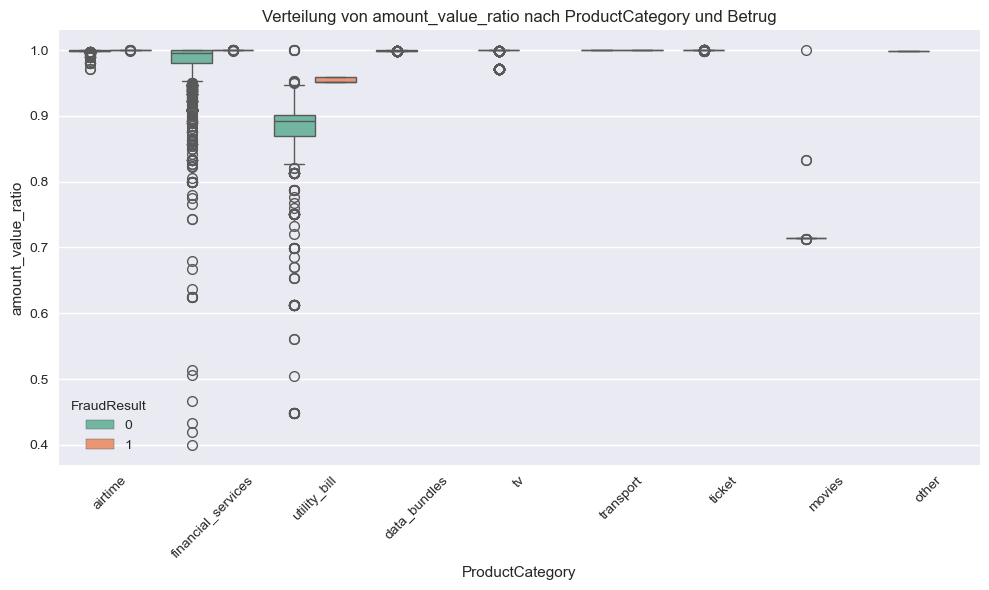

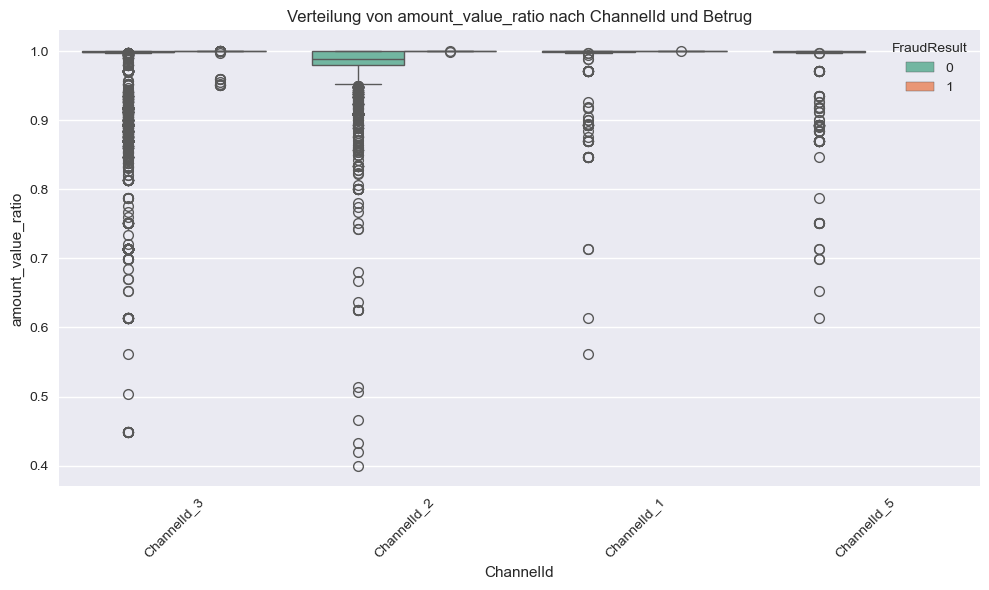

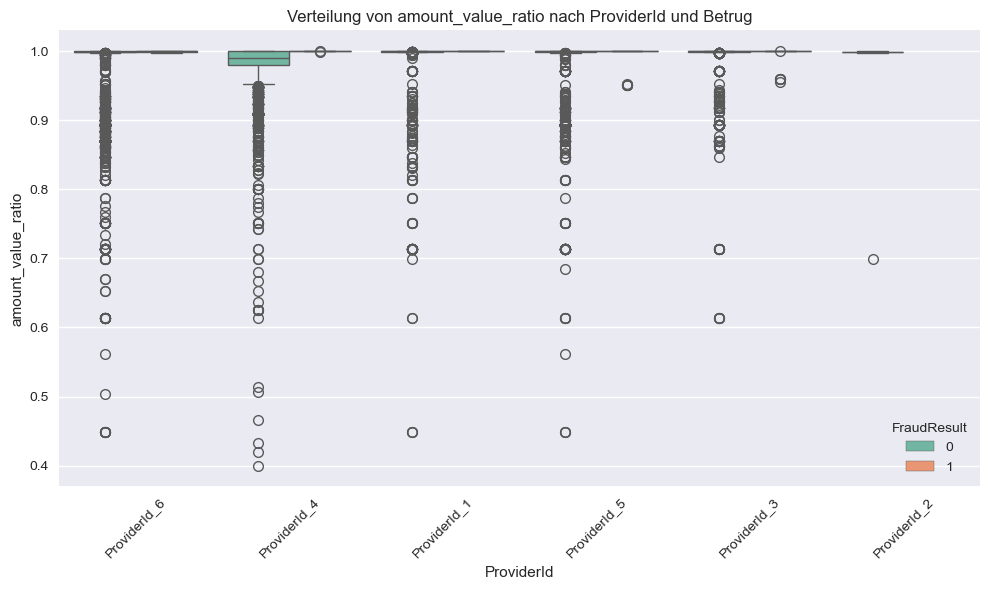

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn-v0_8')
sns.set_palette('Set2')

kategoriale_spalten = ['ProductCategory', 'ChannelId', 'ProviderId']

kombinationen = [('ChannelId', 'ProductCategory'), ('ProviderId', 'ProductCategory')]

for combo in kombinationen:
    fraud_combo = df.groupby(list(combo))['FraudResult'].mean().unstack()
    
    plt.figure(figsize=(10,6))
    sns.heatmap(fraud_combo, annot=True, fmt=".2f", cmap="Reds")
    plt.title(f"Betrugsrate nach {combo[0]} und {combo[1]}")
    plt.ylabel(combo[0])
    plt.xlabel(combo[1])
    plt.tight_layout()
    plt.show()


numerische_spalten = ['Amount', 'Value', 'log_value', 'amount_value_ratio']

for num_col in numerische_spalten:
    for cat_col in kategoriale_spalten:
        plt.figure(figsize=(10,6))
        sns.boxplot(x=cat_col, y=num_col, hue='FraudResult', data=df, palette='Set2')
        plt.xticks(rotation=45)
        plt.title(f"Verteilung von {num_col} nach {cat_col} und Betrug")
        plt.tight_layout()
        plt.show()
